# Working with NARCliM 2.0 Data: Rotated Pole (Original) Grid Analysis and Regridding

This notebook demonstrates best-practice workflows for working with NARCliM 2.0 dynamically downscaled climate data, from analysis on the **rotated pole (original) WRF grid** through to optional regridding onto a regular latitude–longitude grid.

NARCliM 2.0 data are natively provided on a **rotated pole grid** (`rlat`, `rlon`), which is designed to preserve spatial accuracy and model resolution. For many scientific and regional analyses, this native grid is the preferred representation and should be used wherever possible.

However, certain downstream applications—such as interoperability with external datasets, regional summaries, or visualisation in standard GIS tools—may require data on a regular latitude–longitude grid. This notebook therefore covers both approaches:

- **Rotated Pole Grid Analysis** : Demonstrates how to inspect, subset, and visualise NARCliM 2.0 data directly on the native WRF grid while preserving the original model structure.

- **Regridding to a Regular Latitude–Longitude Grid** : Shows how to transform NARCliM 2.0 data to a regular latitude–longitude grid using the `xESMF` regridding library, with careful consideration of appropriate regridding methods and spatial integrity.

Throughout, the emphasis is on understanding the implications of grid choice, applying transformations only when necessary, and maintaining transparent, reproducible workflows suitable for regional-scale climate analysis and visualisation.


<a id="top"></a>

## Notebook structure

- [Requirements](#Requirements)
- [Data Access](#Data-Access)
- [Rotated Pole Grid Analysis](#Rotated-Pole-Grid-Analysis)
- [Crop to Western Australia](#Crop-to-Western-Australia)
- [Plot on Native Rotated Pole Grid](#Plot-on-Native-Rotated-Pole-Grid)
- [Regridding](#Regridding)
- [Conservative Regridding](#Conservative-Regridding)
- [Bilinear Regridding](#Bilinear-Regridding)
- [Downstream Use](#Downstream-Use)
- [Summary](#Summary)


## Requirements

In [1]:
import xarray as xr
import numpy as np
import xesmf as xe
from pathlib import Path
from climate_utils import kelvin_to_celsius
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore') 

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Data Access

The NARCliM dataset is accessed directly from the NCI THREDDS server using the
OpenDAP protocol and the `xarray` library. This approach avoids local downloads
and enables lightweight, reproducible workflows suitable for demonstration and
exploratory analysis.

The dataset used here is monthly maximum temperature (`tasmax`) from the
NARCliM 2.0 ensemble, but the workflow is applicable to any variable with
spatial dimensions.

In [2]:
# Load data from NCI THREDDS server
url = (
    "https://dapds00.nci.org.au/thredds/dodsC/zz63/"
    "NARCliM2-0/output-CMIP6/DD/AUS-18/NSW-Government/"
    "ACCESS-ESM1-5/ssp126/r6i1p1f1/"
    "NARCliM2-0-WRF412R3/v1-r1/mon/tasmax/latest/"
    "tasmax_AUS-18_ACCESS-ESM1-5_ssp126_r6i1p1f1_"
    "NSW-Government_NARCliM2-0-WRF412R3_v1-r1_"
    "mon_201901-201912.nc"
)

ds = xr.open_dataset(url, engine="netcdf4", decode_times=False, cache=False)


tasmax_c = kelvin_to_celsius(ds["tasmax"])


print(f"\nDimensions: {dict(ds.dims)}")
print(f"\nGrid info:")
print(f"  rlat: {len(ds.rlat)} points")
print(f"  rlon: {len(ds.rlon)} points")


Dimensions: {'time': 12, 'rlat': 321, 'rlon': 497, 'bnds': 2, 'crs': 1}

Grid info:
  rlat: 321 points
  rlon: 497 points


In [3]:
# Inspect the coordinate reference system
crs_attrs = ds["crs"].attrs
pole_lat = float(crs_attrs["grid_north_pole_latitude"])
pole_lon = float(crs_attrs["grid_north_pole_longitude"])

print(f"  Pole latitude: {pole_lat}°")
print(f"  Pole longitude: {pole_lon}°")

  Pole latitude: 60.31°
  Pole longitude: 141.38°


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Rotated Pole Grid Analysis 

**This is the preferred approach for most analyses.**

 Working on the native grid:

- Preserves original resolution and accuracy  
- Avoids interpolation artifacts  
- Uses data as the model produced it  
- Is fully supported by standard tools (xarray, cartopy, etc.)


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Crop to Western Australia

First, let's focus on WA to make visualization clearer.

In [4]:
def crop_to_wa(ds):
    """
    Crop dataset to Western Australia region.
    
    Applies np.mod(lon, 360) to handle international dateline crossing.
    """
    # Fix dateline crossing: convert longitude from -180→180 to 0→360
    # Keep as xarray DataArray (not .values)
    lon = np.mod(ds["lon"], 360)
    lat = ds["lat"]
    
    # WA bounding box (now an xarray DataArray)
    wa_mask = (
        (lon >= 108) & (lon <= 130) &
        (lat >= -39) & (lat <= -12)
    )
    
    return ds.where(wa_mask, drop=True)

# Apply crop
ds_wa = crop_to_wa(ds)
ds_wa = ds_wa.assign(tasmax_c=tasmax_c)


print(f"Original grid: {ds.dims['rlat']} × {ds.dims['rlon']} = {ds.dims['rlat'] * ds.dims['rlon']:,} points")
print(f"WA cropped:    {ds_wa.dims['rlat']} × {ds_wa.dims['rlon']} = {ds_wa.dims['rlat'] * ds_wa.dims['rlon']:,} points")

Original grid: 321 × 497 = 159,537 points
WA cropped:    171 × 139 = 23,769 points


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Plot on Native Rotated Pole Grid
This shows how to properly visualize data on its native grid using Cartopy's RotatedPole projection.

In [6]:
def plot_native_wrf(ds, variable, time_index=0, cmap="RdYlBu_r", 
                    tick_spacing=5, title=None, figsize=(6, 6)):
    """
    Plot NARCliM data on its native rotated pole grid.
    
    This is the recommended visualization approach as it:
    - Preserves the original data resolution
    - Avoids interpolation artifacts
    - Correctly handles the rotated coordinate system
    
    Parameters
    ----------
    ds : xarray.Dataset
        NARCliM dataset
    variable : str
        Variable name to plot (e.g., 'tasmax')
    time_index : int
        Time slice to plot
    cmap : str
        Colormap name
    tick_spacing : int
        Spacing for lat/lon grid lines (degrees)
    title : str, optional
        Plot title
    """
    # Get rotated pole projection parameters
    crs_attrs = ds["crs"].attrs
    pole_lat = float(crs_attrs["grid_north_pole_latitude"])
    pole_lon = float(crs_attrs["grid_north_pole_longitude"])
    
    rotated_pole = ccrs.RotatedPole(
        pole_longitude=pole_lon,
        pole_latitude=pole_lat
    )
    
    # Extract data
    da = ds[variable].isel(time=time_index)
    
    # Fix longitude for dateline crossing (convert to numpy for plotting)
    lon = np.mod(ds["lon"].values, 360)
    lat = ds["lat"].values
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=rotated_pole)
    
    # Plot using contourf (handles dateline better than pcolormesh)
    levels = np.linspace(
        np.nanpercentile(da.values, 2),
        np.nanpercentile(da.values, 98),
        20
    )
    
    p = ax.contourf(
        lon, lat, da.values,
        levels=levels,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        extend='both'
    )
    
    # Add coastlines
    ax.coastlines(resolution="50m", linewidth=1.5, color='black')
    
    # Add state boundaries (if available)
    try:
        ax.add_feature(
            ccrs.feature.BORDERS.with_scale('50m'),
            linestyle=':', linewidth=0.8, edgecolor='gray'
        )
    except:
        pass
    
    # Title
    if title is None:
        title = f"Native WRF Grid (Rotated Pole) — {variable.upper()}"
    ax.set_title(title, fontsize=14, weight='bold', pad=15)
    
    # Gridlines
    gl = ax.gridlines(
        draw_labels=True,
        dms=True,
        x_inline=False,
        y_inline=False,
        linestyle='--',
        alpha=0.5,
        color='gray'
    )
    gl.top_labels = False
    gl.right_labels = False
    
    # Set appropriate tick spacing
    lon_min, lon_max = np.nanmin(lon), np.nanmax(lon)
    lat_min, lat_max = np.nanmin(lat), np.nanmax(lat)
    
    gl.xlocator = mticker.FixedLocator(
        np.arange(np.floor(lon_min), np.ceil(lon_max) + 1, tick_spacing)
    )
    gl.ylocator = mticker.FixedLocator(
        np.arange(np.floor(lat_min), np.ceil(lat_max) + 1, tick_spacing)
    )
    
    # Colorbar
    cbar = plt.colorbar(p, ax=ax, orientation="vertical", pad=0.02, shrink=0.8)
    cbar.set_label(da.attrs.get("units", ""), fontsize=12)
    
    plt.tight_layout()
    return fig, ax

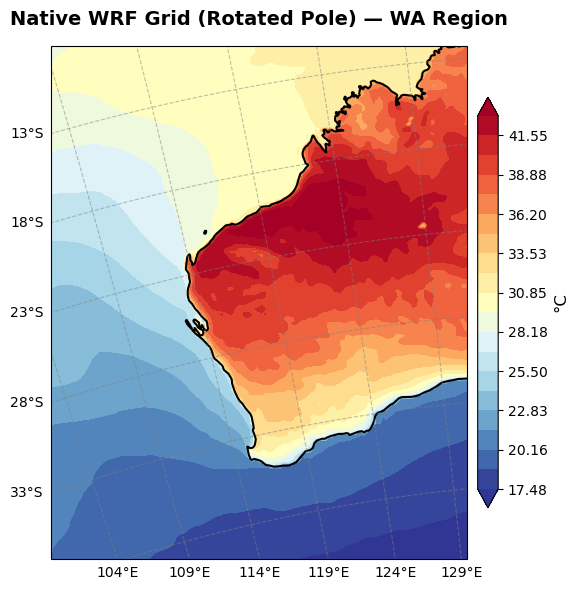

In [7]:
# Plot January 2019
fig, ax = plot_native_wrf(
    ds_wa, 
    "tasmax_c", 
    time_index=0,
    title="Native WRF Grid (Rotated Pole) — WA Region"
)
plt.show()

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Regridding

Regridding is the process of transforming climate model output from its native
grid to a different spatial grid. While NARCliM 2.0 data are provided on a
rotated pole (original) WRF grid, regridding may be required for certain
downstream applications.

Regridding should **not** be treated as a default step. Analyses should be
performed on the native grid wherever possible, with regridding applied only
when there is a clear need.

---

### When to Regrid

Regridding should only be performed when there is a specific analytical or
practical requirement.

 **Valid reasons to regrid:**
- Comparing with observational or reanalysis datasets on a regular grid
- Integrating with other datasets that require regular latitude–longitude grids
- Using analysis or visualisation tools that do not support rotated grids
- User preference for regular grids for interpretability in exploratory work

 **Important regridding principles:**
1. **Use conservative regridding** for precipitation and other conserved variables
2. **Match the resolution** – target grid should be consistent with the native model resolution
3. **Verify results** – always compare regridded output with native-grid output

 **Avoid regridding when:**
- The analysis can be performed on the native rotated grid
- Regridding is done solely for visualisation (native-grid plots are preferred)

---

### Regridding Methods

This notebook uses **xESMF** to perform regridding from the native regional
climate model grid to a regular latitude–longitude grid.

`xESMF` provides multiple regridding algorithms, each with different trade-offs
between accuracy, conservation, and smoothness. The appropriate method depends
on the variable type and analysis purpose.

Commonly used methods include:

- **conservative / conservative_normed** – preserves area-integrated quantities  
  (e.g. precipitation totals and other conserved variables)
- **bilinear** – smooth interpolation, computationally efficient, not conservative
- **nearest_s2d / nearest_d2s** – nearest-neighbour mapping between grids
- **patch** – higher-order interpolation using local polynomial fitting

For a detailed comparison of regridding algorithms, see the official xESMF
documentation:  
https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>


## Conservative Regridding 

When regridding is necessary, **conservative regridding is the default choice** because it:

- Preserves total precipitation over a region
- Maintains energy/mass balance
- Is recommended for all climate variables

### Step 1: Create Grid Corner Bounds

Conservative regridding requires knowing the corners (bounds) of each grid cell.  
We need to create these for both source (rotated) and target (regular) grids.

In [8]:
def add_grid_bounds(ds):
    """
    Add corner bounds to dataset for conservative regridding.
    
    Conservative regridding requires knowing the vertices (corners) of each grid cell.
    This function creates lon_b and lat_b arrays representing cell boundaries.
    
    Based on NSW DPIE methodology for NARCliM processing.
    """
    # Get rotated pole parameters
    crs_attrs = ds["crs"].attrs
    pole_lat = float(crs_attrs["grid_north_pole_latitude"])
    pole_lon = float(crs_attrs["grid_north_pole_longitude"])
    
    # Create cartopy projection
    rot_pole = ccrs.RotatedPole(
        pole_longitude=pole_lon,
        pole_latitude=pole_lat
    )
    plate_carree = ccrs.PlateCarree()
    
    # Calculate rotated coordinates from lat/lon
    lon_2d = ds['lon'].values
    lat_2d = ds['lat'].values
    
    # Transform to rotated coordinates
    tmp = rot_pole.transform_points(plate_carree, lon_2d, lat_2d)
    rlon_2d = tmp[:, :, 0]
    rlat_2d = tmp[:, :, 1]
    
    # Get 1D rotated coordinates (mean along each axis)
    rlon_1d = np.mean(rlon_2d, axis=0)
    rlat_1d = np.mean(rlat_2d, axis=1)
    
    # Calculate grid spacing
    drlon = np.median(np.diff(rlon_1d))
    drlat = np.median(np.diff(rlat_1d))
    
    # Create bounds (cell edges)
    def make_bounds(x, dx):
        """Create cell boundaries from centers"""
        bounds = np.zeros(len(x) + 1)
        bounds[0] = x[0] - dx/2
        bounds[1:-1] = (x[:-1] + x[1:]) / 2
        bounds[-1] = x[-1] + dx/2
        return bounds
    
    rlon_b_1d = make_bounds(rlon_1d, drlon)
    rlat_b_1d = make_bounds(rlat_1d, drlat)
    
    # Create 2D bounds grid
    rlon_b_2d, rlat_b_2d = np.meshgrid(rlon_b_1d, rlat_b_1d)
    
    # Transform back to regular lat/lon
    tmp = plate_carree.transform_points(rot_pole, rlon_b_2d, rlat_b_2d)
    lon_b = np.mod(tmp[:, :, 0], 360)  # Handle dateline
    lat_b = tmp[:, :, 1]
    
    # Add to dataset
    ds_out = ds.copy()
    ds_out['lon_b'] = xr.DataArray(
        lon_b,
        dims=['rlat_b', 'rlon_b'],
        attrs={'long_name': 'longitude bounds', 'units': 'degrees_east'}
    )
    ds_out['lat_b'] = xr.DataArray(
        lat_b,
        dims=['rlat_b', 'rlon_b'],
        attrs={'long_name': 'latitude bounds', 'units': 'degrees_north'}
    )
    
    # Add coordinate bounds
    ds_out = ds_out.assign_coords({
        'rlat_b': rlat_b_1d,
        'rlon_b': rlon_b_1d
    })
    
    print(f"✓ Added grid bounds:")
    print(f"  lon_b shape: {lon_b.shape}")
    print(f"  lat_b shape: {lat_b.shape}")
    print(f"  Grid spacing: drlon={drlon:.3f}°, drlat={drlat:.3f}°")
    
    return ds_out

In [9]:
# Add bounds to source dataset
ds_wa_bounds = add_grid_bounds(ds_wa)

✓ Added grid bounds:
  lon_b shape: (172, 140)
  lat_b shape: (172, 140)
  Grid spacing: drlon=0.176°, drlat=0.176°


### Step 2: Define Target Grid

**Critical:** The target grid resolution should match the native resolution (~18-20km).  
At mid-latitudes (30°S), 0.18° ≈ 20km.

In [10]:
def create_target_grid_wa(resolution_deg=0.18):
    """
    Create regular lat/lon target grid for Western Australia.
    
    Parameters
    ----------
    resolution_deg : float
        Grid spacing in degrees. Default 0.18° ≈ 20km at 30°S latitude.
        This matches NARCliM's native ~18km resolution.
    
    Returns
    -------
    ds_target : xarray.Dataset
        Target grid with lon, lat, lon_b, lat_b
    """
    # WA bounding box with padding
    lon_min, lon_max = 108.0, 130.0
    lat_min, lat_max = -39.0, -12.0
    
    # Create 1D coordinates
    lon_1d = np.arange(lon_min, lon_max + resolution_deg, resolution_deg)
    lat_1d = np.arange(lat_min, lat_max + resolution_deg, resolution_deg)
    
    # Create cell boundaries
    lon_b_1d = np.concatenate([
        [lon_1d[0] - resolution_deg/2],
        (lon_1d[:-1] + lon_1d[1:]) / 2,
        [lon_1d[-1] + resolution_deg/2]
    ])
    
    lat_b_1d = np.concatenate([
        [lat_1d[0] - resolution_deg/2],
        (lat_1d[:-1] + lat_1d[1:]) / 2,
        [lat_1d[-1] + resolution_deg/2]
    ])
    
    # Create 2D grids
    lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)
    lon_b_2d, lat_b_2d = np.meshgrid(lon_b_1d, lat_b_1d)
    
    # Create xarray Dataset
    ds_target = xr.Dataset({
        'lon': xr.DataArray(
            lon_2d,
            dims=['lat', 'lon'],
            attrs={'standard_name': 'longitude', 'units': 'degrees_east'}
        ),
        'lat': xr.DataArray(
            lat_2d,
            dims=['lat', 'lon'],
            attrs={'standard_name': 'latitude', 'units': 'degrees_north'}
        ),
        'lon_b': xr.DataArray(
            lon_b_2d,
            dims=['lat_b', 'lon_b'],
            attrs={'long_name': 'longitude bounds'}
        ),
        'lat_b': xr.DataArray(
            lat_b_2d,
            dims=['lat_b', 'lon_b'],
            attrs={'long_name': 'latitude bounds'}
        )
    })
    
    # Add 1D coordinates
    ds_target = ds_target.assign_coords({
        'lon': lon_1d,
        'lat': lat_1d,
        'lon_b': lon_b_1d,
        'lat_b': lat_b_1d
    })
    
    print(f"✓ Target grid created:")
    print(f"  Resolution: {resolution_deg}° (~{resolution_deg * 111:.0f}km at equator, ~{resolution_deg * 111 * np.cos(np.radians(25)):.0f}km at 25°S)")
    print(f"  Dimensions: {len(lat_1d)} lat × {len(lon_1d)} lon = {len(lat_1d) * len(lon_1d):,} points")
    print(f"  Coverage: {lon_min}°E to {lon_max}°E, {lat_min}°N to {lat_max}°N")
    
    return ds_target

# Create target grid (0.18° ≈ 20km, matching NARCliM resolution)
ds_target = create_target_grid_wa(resolution_deg=0.18)

✓ Target grid created:
  Resolution: 0.18° (~20km at equator, ~18km at 25°S)
  Dimensions: 151 lat × 124 lon = 18,724 points
  Coverage: 108.0°E to 130.0°E, -39.0°N to -12.0°N


### Step 3: Perform Conservative Regridding
Use xESMF's conservative method to preserve mass/energy.

In [11]:
# Create conservative regridder
print("Creating conservative regridder...")
print("This may take 1-2 minutes as it computes overlap areas between grids.\n")

regridder_conservative = xe.Regridder(
    ds_wa_bounds,
    ds_target,
    method='conservative',
    periodic=False,
    filename='regrid_weights_conservative.nc',  # Cache weights for reuse
    reuse_weights=False  # Set to True after first run to speed up
)

print("✓ Regridder created successfully!")
print(f"  Method: conservative")
print(f"  Source grid: {ds_wa_bounds.dims['rlat']} × {ds_wa_bounds.dims['rlon']}")
print(f"  Target grid: {len(ds_target.lat)} × {len(ds_target.lon)}")

Creating conservative regridder...
This may take 1-2 minutes as it computes overlap areas between grids.

✓ Regridder created successfully!
  Method: conservative
  Source grid: 171 × 139
  Target grid: 151 × 124


In [12]:
# Apply regridding to tasmax
print("Applying conservative regridding to tasmax...")

tasmax_regridded = regridder_conservative(ds_wa_bounds['tasmax'])

print("✓ Regridding complete!")
print(f"  Original shape: {ds_wa_bounds['tasmax'].shape}")
print(f"  Regridded shape: {tasmax_regridded.shape}")

# Create regridded dataset
ds_regridded = xr.Dataset({
    'tasmax': tasmax_regridded
})

# Add metadata
ds_regridded.attrs.update({
    'title': 'Regridded NARCliM 2.0 Data - Conservative Method',
    'source': 'NARCliM 2.0 via NCI THREDDS',
    'regridding_method': 'conservative (xESMF)',
    'original_grid': 'WRF rotated pole (rlat, rlon)',
    'target_grid': 'Regular lat/lon 0.18° (~20km)',
    'notes': 'Conservative regridding preserves mass/energy balance'
})

ds_regridded

Applying conservative regridding to tasmax...
✓ Regridding complete!
  Original shape: (12, 171, 139)
  Regridded shape: (12, 151, 124)


<xarray.Dataset> Size: 901kB
Dimensions:  (time: 12, lon: 124, lat: 151)
Coordinates:
  * time     (time) float64 96B 2.525e+04 2.528e+04 ... 2.555e+04 2.558e+04
  * lon      (lon) float64 992B 108.0 108.2 108.4 108.5 ... 129.8 130.0 130.1
  * lat      (lat) float64 1kB -39.0 -38.82 -38.64 ... -12.36 -12.18 -12.0
    height   float64 8B 2.0
Data variables:
    tasmax   (time, lat, lon) float32 899kB nan 79.28 144.8 ... 253.3 nan nan
Attributes:
    title:              Regridded NARCliM 2.0 Data - Conservative Method
    source:             NARCliM 2.0 via NCI THREDDS
    regridding_method:  conservative (xESMF)
    original_grid:      WRF rotated pole (rlat, rlon)
    target_grid:        Regular lat/lon 0.18° (~20km)
    notes:              Conservative regridding preserves mass/energy balance

### Regridded

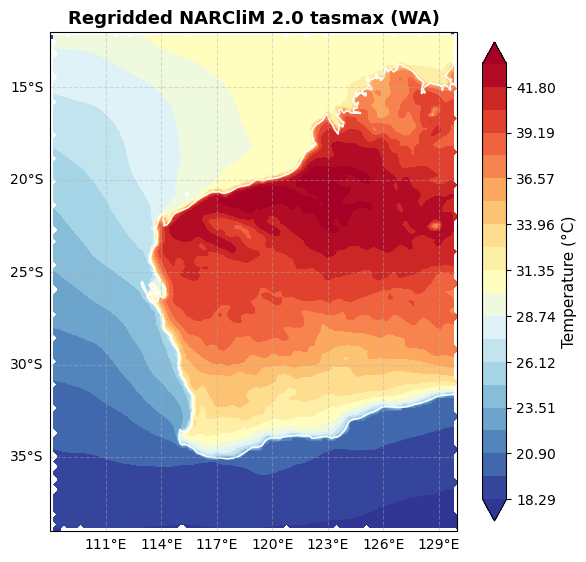

In [13]:
# ================================
# Regridded NARCliM tasmax (WA) 
# ================================

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Convert to Celsius
regrid_c = kelvin_to_celsius(ds_regridded['tasmax']).isel(time=0)

# Coordinates
lon = ds_regridded['lon'].values
lat = ds_regridded['lat'].values
data = regrid_c.values

# Robust color scale
vmin = np.nanpercentile(data, 2)
vmax = np.nanpercentile(data, 98)
levels = np.linspace(vmin, vmax, 20)

# Figure
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot
im = ax.contourf(
    lon, lat, data,
    levels=levels,
    cmap='RdYlBu_r',
    transform=ccrs.PlateCarree(),
    extend='both'
)

# Coastlines + extent
ax.coastlines(resolution='50m', linewidth=1.2, color='white')
ax.set_extent([108, 130, -39, -12], crs=ccrs.PlateCarree())

# Gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.4)
gl.top_labels = False
gl.right_labels = False

# Title
ax.set_title(
    'Regridded NARCliM 2.0 tasmax (WA)',
    fontsize=13, weight='bold'
)

# Colorbar
cbar = plt.colorbar(im, orientation='vertical', pad=0.05, shrink=0.9)
cbar.set_label('Temperature (°C)', fontsize=11)

plt.tight_layout()
plt.show()


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>


### Save Regridded Data

In [14]:
# Save to NetCDF
output_dir = Path("output/regridded")
output_dir.mkdir(parents=True, exist_ok=True)

outfile = output_dir / "tasmax_regridded_wa_conservative_0p18deg.nc"
ds_regridded.to_netcdf(outfile)

print(f"✓ Regridded data saved to: {outfile}")
print(f"  File size: {outfile.stat().st_size / 1024 / 1024:.1f} MB")

✓ Regridded data saved to: output/regridded/tasmax_regridded_wa_conservative_0p18deg.nc
  File size: 0.9 MB


## Bilinear Regridding

In [15]:
target_grid = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-38.5, -12.0, 0.18)),  # ~20 km
        "lon": (["lon"], np.arange(108.0, 130.0, 0.18)),
    }
)

target_grid


<xarray.Dataset> Size: 2kB
Dimensions:  (lat: 148, lon: 123)
Coordinates:
  * lat      (lat) float64 1kB -38.5 -38.32 -38.14 ... -12.4 -12.22 -12.04
  * lon      (lon) float64 984B 108.0 108.2 108.4 108.5 ... 129.6 129.8 130.0
Data variables:
    *empty*

In [16]:
regridder = xe.Regridder(
    ds_wa,
    target_grid,
    method="bilinear",
    reuse_weights=False
)

In [17]:
from climate_utils import kelvin_to_celsius
tasmax_rg = regridder(ds_wa["tasmax"])
tasmax_rg = kelvin_to_celsius(tasmax_rg)


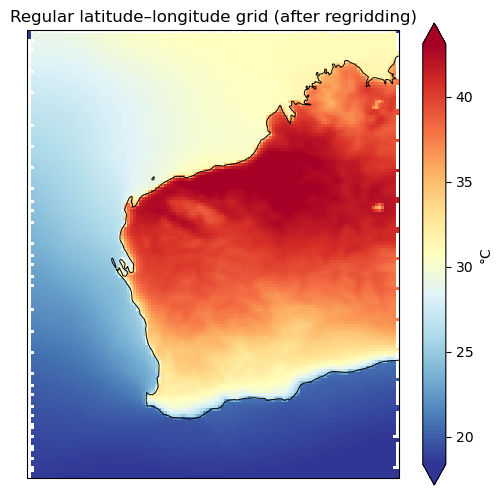

In [18]:
# Regridded output (regular lat–lon grid)
tasmax_regridded = tasmax_rg.isel(time=0)

plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

tasmax_regridded.plot(
    ax=ax,
    cmap="RdYlBu_r",
    robust=True,
    cbar_kwargs={"label": tasmax_regridded.attrs.get("units", "degC")}
)

ax.coastlines(resolution="50m", linewidth=0.7)
ax.set_title("Regular latitude–longitude grid (after regridding)")
plt.show()


## Regridding multiple variables

This section automatically regrids **all spatial variables** from the original dataset (not just `tasmax`). 

The loop identifies variables with `rlat`/`rlon` dimensions, applies the pre-built regridder, and collects them into a single clean Dataset:

In [19]:
regridded_vars = {}

for var in ds_wa.data_vars:
    da = ds_wa[var]
    if {"rlat", "rlon"}.issubset(da.dims):
        print(f"Regridding {var}")
        regridded_vars[var] = regridder(da)
    else:
        print(f"Skipping {var}")

regridded_ds = xr.Dataset(regridded_vars)
regridded_ds


Regridding tasmax
Regridding tasmax_c


<xarray.Dataset> Size: 2MB
Dimensions:   (time: 12, lat: 148, lon: 123)
Coordinates:
  * time      (time) float64 96B 2.525e+04 2.528e+04 ... 2.555e+04 2.558e+04
  * lat       (lat) float64 1kB -38.5 -38.32 -38.14 ... -12.4 -12.22 -12.04
  * lon       (lon) float64 984B 108.0 108.2 108.4 108.5 ... 129.6 129.8 130.0
    height    float64 8B 2.0
Data variables:
    tasmax    (time, lat, lon) float32 874kB nan 291.8 291.8 ... 303.9 303.9 0.0
    tasmax_c  (time, lat, lon) float32 874kB 18.68 18.68 18.68 ... 30.78 0.0

## Saving Regridded Data
This finalizes and saves the regridded Dataset to NetCDF with full provenance metadata.

Add global attributes documenting source, method, and processing history
Create output directory safely (mkdir -p equivalent)
Save as self-contained .nc file ready for analysis/sharing

The metadata travels with the file and shows up in ncdump -h or ds.attrs.

In [20]:
regridded_ds.attrs.update({
    "title": "Regridded NARCliM 2.0 Data",
    "source": "NARCliM 2.0 via NCI THREDDS",
    "regridding_method": "bilinear",
    "original_grid": "WRF rotated lat-lon (rlat, rlon)",
    "notes": "Regridded to regular latitude–longitude grid for analysis"
})

In [21]:
output_dir = Path("output/regridded")
output_dir.mkdir(parents=True, exist_ok=True)

outfile = output_dir / "tasmax_bilinear_regridded_wa_0p18deg.nc"
regridded_ds.to_netcdf(outfile)

outfile

PosixPath('output/regridded/tasmax_bilinear_regridded_wa_0p18deg.nc')

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Downstream Use

This notebook is intentionally limited to spatial transformation only.
The regridded NetCDF outputs produced here are intended to be used as inputs
to downstream notebooks that perform:

- Use regridded output for regional aggregation 
- Extend to multiple variables (pr, tasmin, etc.)
- Process multi-year datasets
- Integrate with observational data

This separation of concerns improves clarity, reproducibility, and maintainability
of the overall analysis workflow.
<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Summary

This notebook provides a reproducible example of how to regrid NARCliM 2.0 data
from its native rotated WRF grid to a regular latitude–longitude grid using xESMF.
The resulting datasets form a clean and consistent spatial foundation for
subsequent climate analysis and reporting.

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>